In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [3]:
import json
import asyncio
import weave
from weave.scorers import MultiTaskBinaryClassificationF1
import openai

# We create a model class with one predict function.
# All inputs, predictions and parameters are automatically captured for easy inspection.

class ExtractFruitsModel(weave.Model):
    model_name: str
    prompt_template: str

    @weave.op()
    async def predict(self, sentence: str) -> dict:
        client = openai.AsyncClient()

        response = await client.chat.completions.create(
            model=self.model_name,
            messages=[
                {"role": "user", "content": self.prompt_template.format(sentence=sentence)}
            ],
            response_format={ "type": "json_object" }
        )
        result = response.choices[0].message.content
        if result is None:
            raise ValueError("No response from model")
        parsed = json.loads(result)
        return parsed

# We call init to begin capturing data in the project, intro-example.
weave.init('intro-example')

# We create our model with our system prompt.
model = ExtractFruitsModel(name='gpt4',
                        model_name='gpt-4-0125-preview',
                        prompt_template='Extract fields ("fruit": <str>, "color": <str>, "flavor") from the following text, as json: {sentence}')
sentences = ["There are many fruits that were found on the recently discovered planet Goocrux. There are neoskizzles that grow there, which are purple and taste like candy.",
"Pounits are a bright green color and are more savory than sweet.",
"Finally, there are fruits called glowls, which have a very sour and bitter taste which is acidic and caustic, and a pale orange tinge to them."]
labels = [
    {'fruit': 'neoskizzles', 'color': 'purple', 'flavor': 'candy'},
    {'fruit': 'pounits', 'color': 'bright green', 'flavor': 'savory'},
    {'fruit': 'glowls', 'color': 'pale orange', 'flavor': 'sour and bitter'}
]
examples = [
    {'id': '0', 'sentence': sentences[0], 'target': labels[0]},
    {'id': '1', 'sentence': sentences[1], 'target': labels[1]},
    {'id': '2', 'sentence': sentences[2], 'target': labels[2]}
]
# We define a scoring function to compare our model predictions with a ground truth label.
@weave.op()
def fruit_name_score(target: dict, output: dict) -> dict:
    return {'correct': target['fruit'] == output['fruit']}

# Finally, we run an evaluation of this model.
# This will generate a prediction for each input example, and then score it with each scoring function.
evaluation = weave.Evaluation(
    name='fruit_eval',
    dataset=examples, scorers=[MultiTaskBinaryClassificationF1(class_names=["fruit", "color", "flavor"]), fruit_name_score],
)
print(await evaluation.evaluate(model))

Evaluated 1 of 3 examples

Evaluated 2 of 3 examples

Evaluated 3 of 3 examples

Evaluation summary
{
    'MultiTaskBinaryClassificationF1': {
        'fruit': {'f1': 0.8, 'precision': 0.6666666666666666, 'recall': 1.0},
        'color': {'f1': 1.0, 'precision': 1.0, 'recall': 1.0},
        'flavor': {'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
    },
    'fruit_name_score': {'correct': {'true_count': 2, 'true_fraction': 0.6666666666666666}},
    'model_latency': {'mean': 3.3017086187998452}
}

{'MultiTaskBinaryClassificationF1': {'fruit': {'f1': 0.8, 'precision': 0.6666666666666666, 'recall': 1.0}, 'color': {'f1': 1.0, 'precision': 1.0, 'recall': 1.0}, 'flavor': {'f1': 1.0, 'precision': 1.0, 'recall': 1.0}}, 'fruit_name_score': {'correct': {'true_count': 2, 'true_fraction': 0.6666666666666666}}, 'model_latency': {'mean': 3.3017086187998452}}


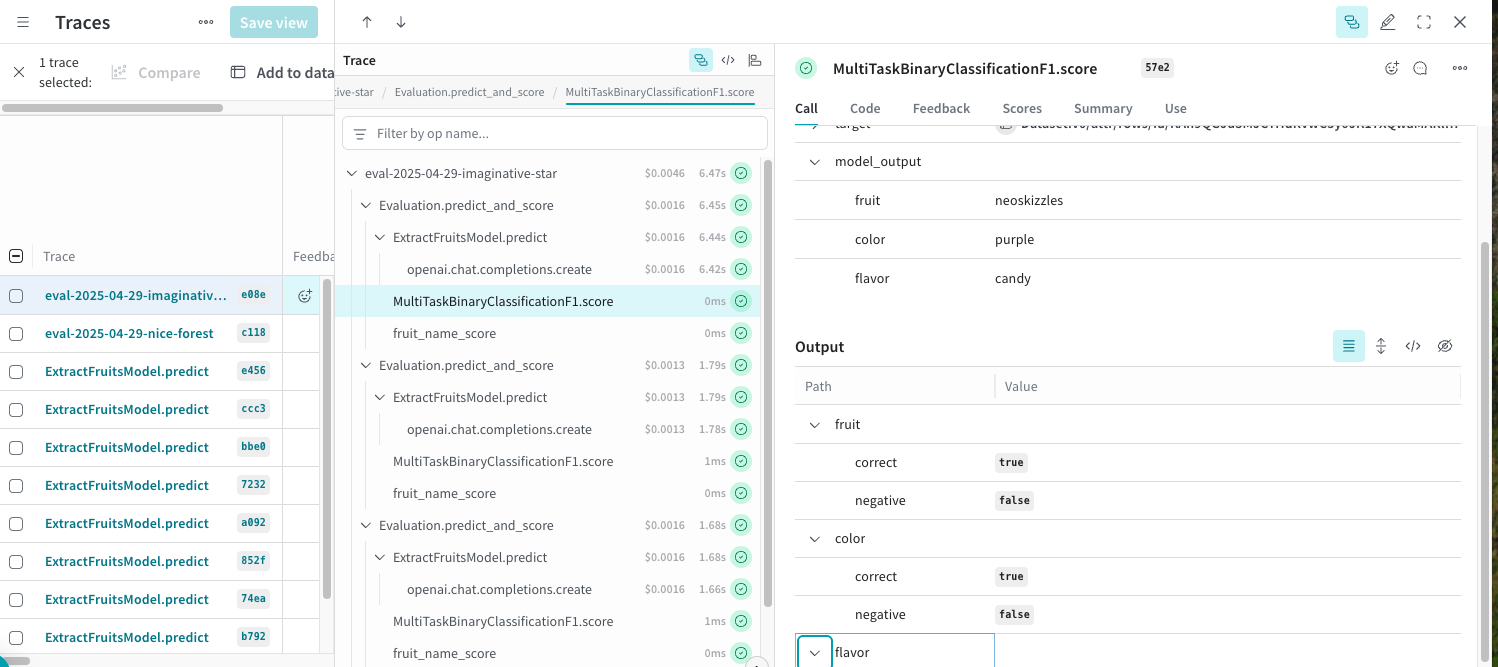